In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA, NMF, TruncatedSVD, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import lightgbm as lgb
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train_selected_features.csv')
test_df = pd.read_csv('test_selected_features.csv')

train_df.head()

,data_channel_is_entertainment,max_positive_polarity,num_self_hrefs,num_videos,abs_title_sentiment_polarity,min_negative_polarity,abs_title_subjectivity,min_positive_polarity,n_non_stop_words,rate_positive_words,...,kw_avg_max,self_reference_min_shares,LDA_02,LDA_01,LDA_04,kw_max_avg,self_reference_avg_sharess,timedelta,kw_avg_avg,log_shares
0,1.0,1.0,4.0,0.0,0.000000,-1.0,0.150000,0.033333,1.0,0.750000,...,279725.000000,2200.0,0.324021,0.524944,0.050000,3259.745585,2600.000000,458.0,2519.643194,6.602588
1,0.0,0.6,0.0,0.0,0.000000,0.0,0.500000,0.200000,1.0,1.000000,...,29266.666667,0.0,0.194398,0.033348,0.705548,2867.051724,0.000000,693.0,2176.268224,7.313887
2,0.0,0.8,1.0,0.0,0.230000,-0.3,0.130000,0.100000,1.0,0.692308,...,191200.000000,851.0,0.866588,0.033345,0.033381,4368.468571,851.000000,151.0,2819.365085,7.313887
3,0.0,1.0,3.0,1.0,0.131818,-0.5,0.077273,0.100000,1.0,0.750000,...,382516.666667,698.0,0.033903,0.033338,0.033335,7489.815789,1174.666667,478.0,2960.399900,6.084499
4,0.0,1.0,2.0,6.0,0.250000,-0.5,0.250000,0.100000,1.0,0.575758,...,293814.285714,812.0,0.729790,0.028573,0.184493,3450.057374,1256.000000,74.0,2562.631111,7.090910


In [3]:
X_train = train_df.drop(['log_shares'], axis=1)
y_train = train_df['log_shares']
X_test = test_df.drop(['log_shares'], axis=1)
y_test = test_df['log_shares']

In [4]:
X_train.head()

,data_channel_is_entertainment,max_positive_polarity,num_self_hrefs,num_videos,abs_title_sentiment_polarity,min_negative_polarity,abs_title_subjectivity,min_positive_polarity,n_non_stop_words,rate_positive_words,...,global_subjectivity,kw_avg_max,self_reference_min_shares,LDA_02,LDA_01,LDA_04,kw_max_avg,self_reference_avg_sharess,timedelta,kw_avg_avg
0,1.0,1.0,4.0,0.0,0.000000,-1.0,0.150000,0.033333,1.0,0.750000,...,0.506845,279725.000000,2200.0,0.324021,0.524944,0.050000,3259.745585,2600.000000,458.0,2519.643194
1,0.0,0.6,0.0,0.0,0.000000,0.0,0.500000,0.200000,1.0,1.000000,...,0.393290,29266.666667,0.0,0.194398,0.033348,0.705548,2867.051724,0.000000,693.0,2176.268224
2,0.0,0.8,1.0,0.0,0.230000,-0.3,0.130000,0.100000,1.0,0.692308,...,0.391832,191200.000000,851.0,0.866588,0.033345,0.033381,4368.468571,851.000000,151.0,2819.365085
3,0.0,1.0,3.0,1.0,0.131818,-0.5,0.077273,0.100000,1.0,0.750000,...,0.720875,382516.666667,698.0,0.033903,0.033338,0.033335,7489.815789,1174.666667,478.0,2960.399900
4,0.0,1.0,2.0,6.0,0.250000,-0.5,0.250000,0.100000,1.0,0.575758,...,0.429898,293814.285714,812.0,0.729790,0.028573,0.184493,3450.057374,1256.000000,74.0,2562.631111


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


Training set shape: (31715, 48)
Test set shape: (7929, 48)


In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    return {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }

In [7]:
def create_lgb_model():
    return lgb.LGBMRegressor(**{'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.037507980506492504, 'num_leaves': 223,
                                 'lambda_l1': 0.30553089435261865, 'lambda_l2': 0.7674806328883184, 'min_child_samples': 44}, verbose=-1)

# PCA


In [8]:
all_results = []
explained_variances = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [9]:
for ev in explained_variances:
    print(f"\nTesting PCA with {ev} explained variance...")
    
    pca = PCA(n_components=ev)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model = create_lgb_model()
    model.fit(X_train_pca, y_train)
    
    y_pred = model.predict(X_test_pca)
    
    metrics = evaluate_model(y_test, y_pred)
    metrics['technique'] = 'PCA'
    metrics['params'] = f'{ev} explained variance'
    metrics['n_components'] = X_train_pca.shape[1]

    print(f"Components: {X_train_pca.shape[1]}, "
          f"MSE: {metrics['MSE']:.4f}, "
          f"R²: {metrics['R²']:.4f}",)


Testing PCA with 0.5 explained variance...
Components: 8, MSE: 0.7747, R²: 0.0910

Testing PCA with 0.6 explained variance...
Components: 10, MSE: 0.7706, R²: 0.0958

Testing PCA with 0.7 explained variance...
Components: 13, MSE: 0.7698, R²: 0.0968

Testing PCA with 0.8 explained variance...
Components: 18, MSE: 0.7561, R²: 0.1129

Testing PCA with 0.9 explained variance...
Components: 24, MSE: 0.7482, R²: 0.1221

Testing PCA with 0.95 explained variance...
Components: 29, MSE: 0.7456, R²: 0.1251

Testing PCA with 0.99 explained variance...
Components: 36, MSE: 0.7440, R²: 0.1270


In [10]:
specific_components = [10, 13, 18, 23, 30, 36, 45]

In [11]:
for n_comp in specific_components:
    if n_comp <= X_train_scaled.shape[1]:
        print(f"\nTesting PCA with {n_comp} components...")
        
        pca = PCA(n_components=n_comp)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        model = create_lgb_model()
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        
        metrics = evaluate_model(y_test, y_pred)
        metrics['technique'] = 'PCA'
        metrics['params'] = f'{n_comp} components'
        metrics['n_components'] = n_comp
        
        all_results.append(metrics)
        
        print(f"MSE: {metrics['MSE']:.4f}, R²: {metrics['R²']:.4f}")


Testing PCA with 10 components...
MSE: 0.7706, R²: 0.0958

Testing PCA with 13 components...
MSE: 0.7698, R²: 0.0968

Testing PCA with 18 components...
MSE: 0.7561, R²: 0.1129

Testing PCA with 23 components...
MSE: 0.7467, R²: 0.1239

Testing PCA with 30 components...
MSE: 0.7442, R²: 0.1268

Testing PCA with 36 components...
MSE: 0.7440, R²: 0.1270

Testing PCA with 45 components...
MSE: 0.7418, R²: 0.1295


# NMF


In [12]:
X_train_nonneg = X_train_scaled - X_train_scaled.min() + 1e-6
X_test_nonneg = X_test_scaled - X_test_scaled.min() + 1e-6

In [13]:
nmf_components = [10, 13, 18, 23, 30, 36, 45]

In [14]:
for n_comp in nmf_components:
    if n_comp <= X_train_scaled.shape[1]:
        print(f"\nTesting NMF with {n_comp} components...")
        
        try:
            nmf = NMF(n_components=n_comp, random_state=42, max_iter=1000)
            X_train_nmf = nmf.fit_transform(X_train_nonneg)
            X_test_nmf = nmf.transform(X_test_nonneg)
            
            model = create_lgb_model()
            model.fit(X_train_nmf, y_train)
            y_pred = model.predict(X_test_nmf)
            
            metrics = evaluate_model(y_test, y_pred)
            metrics['technique'] = 'NMF'
            metrics['params'] = f'{n_comp} components'
            metrics['n_components'] = n_comp
            
            all_results.append(metrics)
            
            print(f"MSE: {metrics['MSE']:.4f}, R²: {metrics['R²']:.4f}")
            
        except Exception as e:
            print(f"NMF failed for {n_comp} components: {str(e)}")


Testing NMF with 10 components...
MSE: 0.9058, R²: -0.0628

Testing NMF with 13 components...
MSE: 0.8725, R²: -0.0238

Testing NMF with 18 components...
MSE: 0.8614, R²: -0.0107

Testing NMF with 23 components...
MSE: 0.8112, R²: 0.0481

Testing NMF with 30 components...
MSE: 0.8305, R²: 0.0256

Testing NMF with 36 components...
MSE: 0.8254, R²: 0.0316

Testing NMF with 45 components...
MSE: 0.9185, R²: -0.0778


# Factor Analysis


In [15]:
fa_components = [10, 13, 18, 23, 30, 36, 45]

In [16]:
for n_comp in fa_components:
    if n_comp <= X_train_scaled.shape[1]:
        print(f"\nTesting Factor Analysis with {n_comp} components...")
        
        try:
            fa = FactorAnalysis(n_components=n_comp, random_state=42)
            X_train_fa = fa.fit_transform(X_train_scaled)
            X_test_fa = fa.transform(X_test_scaled)
            
            model = create_lgb_model()
            model.fit(X_train_fa, y_train)
            y_pred = model.predict(X_test_fa)
            
            metrics = evaluate_model(y_test, y_pred)
            metrics['technique'] = 'Factor Analysis'
            metrics['params'] = f'{n_comp} components'
            metrics['n_components'] = n_comp
            
            all_results.append(metrics)
            
            print(f"MSE: {metrics['MSE']:.4f}, R²: {metrics['R²']:.4f}")
            
        except Exception as e:
            print(f"Factor Analysis failed for {n_comp} components: {str(e)}")


Testing Factor Analysis with 10 components...
MSE: 0.7759, R²: 0.0895

Testing Factor Analysis with 13 components...
MSE: 0.7712, R²: 0.0951

Testing Factor Analysis with 18 components...
MSE: 0.7565, R²: 0.1123

Testing Factor Analysis with 23 components...
MSE: 0.7582, R²: 0.1104

Testing Factor Analysis with 30 components...
MSE: 0.7496, R²: 0.1205

Testing Factor Analysis with 36 components...
MSE: 0.7439, R²: 0.1271

Testing Factor Analysis with 45 components...
MSE: 0.7331, R²: 0.1398


# Evaluation


In [17]:
results_df = pd.DataFrame(all_results)

In [18]:
best_by_technique = results_df.loc[results_df.groupby('technique')['R²'].idxmax()]
best_by_technique = best_by_technique.sort_values('R²', ascending=False)

for _, row in best_by_technique.iterrows():
    print(f"{row['technique']:15} | {row['params']:20} | "
          f"R²: {row['R²']:.4f} | MSE: {row['MSE']:.4f} | "
          f"Components: {row['n_components']}")

Factor Analysis | 45 components        | R²: 0.1398 | MSE: 0.7331 | Components: 45
PCA             | 45 components        | R²: 0.1295 | MSE: 0.7418 | Components: 45
NMF             | 23 components        | R²: 0.0481 | MSE: 0.8112 | Components: 23


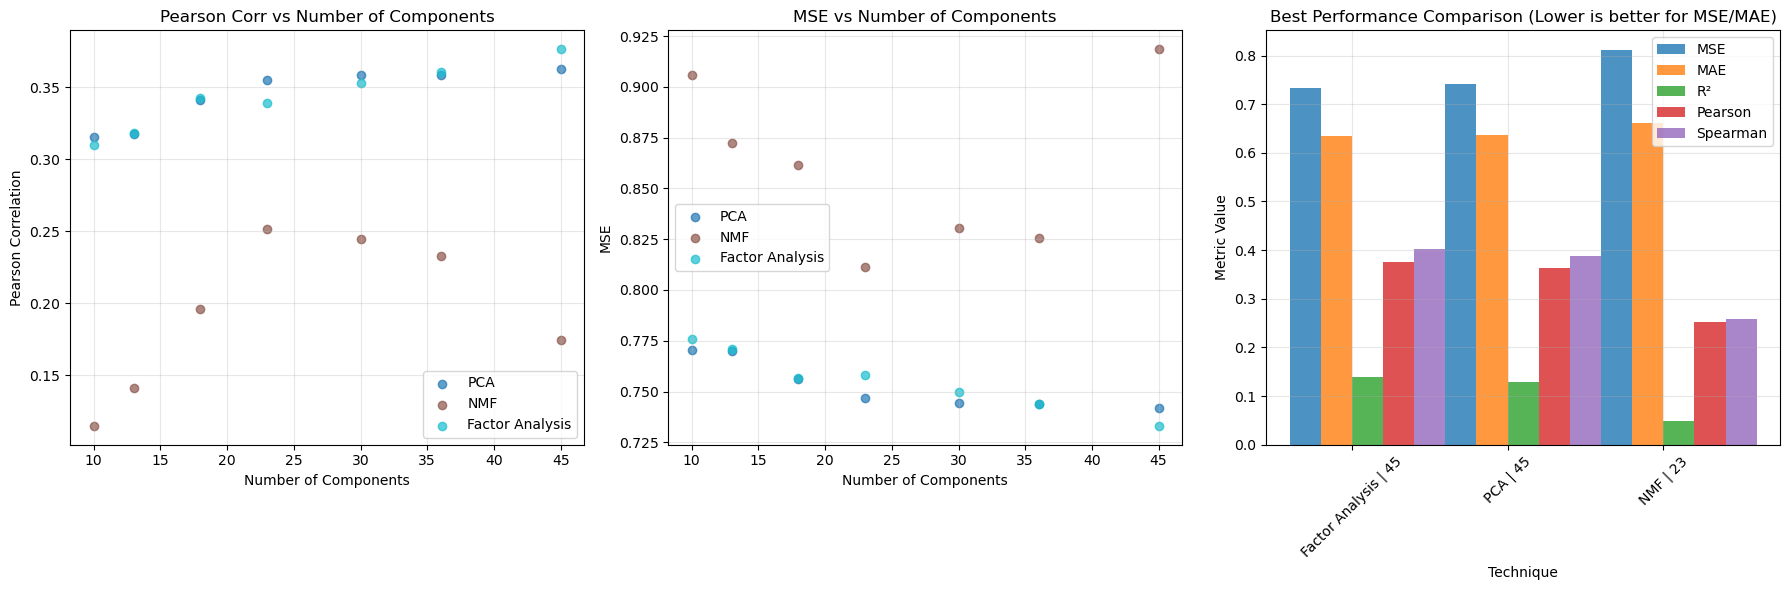

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
techniques = results_df['technique'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(techniques)))

# First subplot: Pearson Correlation vs Components
for i, technique in enumerate(techniques):
    tech_data = results_df[results_df['technique'] == technique]
    axes[0].scatter(tech_data['n_components'], tech_data['Pearson'],
                   label=technique, alpha=0.7, color=colors[i])

axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Pearson Correlation')
axes[0].set_title('Pearson Corr vs Number of Components')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Second subplot: MSE vs Components
for i, technique in enumerate(techniques):
    tech_data = results_df[results_df['technique'] == technique]
    axes[1].scatter(tech_data['n_components'], tech_data['MSE'],
                   label=technique, alpha=0.7, color=colors[i])

axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE vs Number of Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Third subplot: Best Performance Comparison
best_metrics = ['MSE', 'MAE', 'R²', 'Pearson', 'Spearman']
x_pos = np.arange(len(best_by_technique))

for i, metric in enumerate(best_metrics):
    axes[2].bar(x_pos + i*0.2, best_by_technique[metric],
               width=0.2, label=metric, alpha=0.8)

axes[2].set_xlabel('Technique')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('Best Performance Comparison (Lower is better for MSE/MAE)')
axes[2].set_xticks(x_pos + 0.3)
labels = [f"{tech} | {n_comp}" for tech, n_comp in zip(best_by_technique['technique'], best_by_technique['n_components'])]
axes[2].set_xticklabels(labels, rotation=45)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
summary_stats = results_df.groupby('technique').agg({
    'R²': ['mean', 'std', 'max'],
    'MSE': ['mean', 'std', 'min'],
    'n_components': ['mean', 'min', 'max']
}).round(4)

summary_stats

R²                     MSE                 n_components  \
                   mean     std     max    mean     std     min         mean   
technique                                                                      
Factor Analysis  0.1135  0.0175  0.1398  0.7555  0.0150  0.7331         25.0   
NMF             -0.0100  0.0482  0.0481  0.8608  0.0411  0.8112         25.0   
PCA              0.1161  0.0145  0.1295  0.7533  0.0124  0.7418         25.0   

                         
                min max  
technique                
Factor Analysis  10  45  
NMF              10  45  
PCA              10  45

In [ ]:
best_model = results_df.loc[results_df['Pearson'].idxmax()]
print(f"\n{'='*80}")
print(f"OVERALL BEST MODEL")
print(f"{'='*80}")
print(f"Technique: {best_model['technique']}")
print(f"Parameters: {best_model['params']}")
print(f"Components: {best_model['n_components']}")
print(f"R² Score: {best_model['R²']:.4f}")
print(f"MSE: {best_model['MSE']:.4f}")
print(f"MAE: {best_model['MAE']:.4f}")
print(f"Pearson Correlation: {best_model['Pearson']:.4f}")
print(f"Spearman Correlation: {best_model['Spearman']:.4f}")


OVERALL BEST MODEL
Technique: Factor Analysis
Parameters: 45 components
Components: 45
R² Score: 0.1398
MSE: 0.7331
MAE: 0.6339
Pearson Correlation: 0.3766
Spearman Correlation: 0.4030


In [ ]:
top_models = results_df.nsmallest(10, 'MSE')[['technique', 'params', 'n_components', 'MSE', 'MAE', 'R²', 'Pearson', 'Spearman']].reset_index(drop=True)
top_models

,technique,params,n_components,MSE,MAE,R²,Pearson,Spearman
0,Factor Analysis,45 components,45,0.733094,0.633884,0.139811,0.376632,0.403012
1,PCA,45 components,45,0.741839,0.637028,0.129550,0.363142,0.387171
2,Factor Analysis,36 components,36,0.743948,0.640947,0.127076,0.360924,0.378846
3,PCA,36 components,36,0.743986,0.638660,0.127031,0.358851,0.382866
4,PCA,30 components,30,0.744170,0.639481,0.126815,0.358557,0.377779
5,PCA,23 components,23,0.746652,0.640099,0.123903,0.355337,0.377306
6,Factor Analysis,30 components,30,0.749584,0.643631,0.120463,0.353194,0.368252
7,PCA,18 components,18,0.756058,0.644719,0.112866,0.340982,0.364465
8,Factor Analysis,18 components,18,0.756517,0.647249,0.112328,0.342718,0.358615
9,Factor Analysis,23 components,23,0.758187,0.649066,0.110369,0.339046,0.352259


Following our initial hyperparameter tuning, we observed the LGBM model was performing the best so we chose it as our candidate to test the dimensionality reduction.

To quickly understand the context of our aproach, the techniques used were PCA, NMF and Factor Analysis:

PCA (Principal Component Analysis)
What it's for:

General purpose dimensionality reduction
Data compression and noise reduction
Creating uncorrelated features for machine learning
Exploratory data analysis

Best for: Any numerical data where you want to preserve maximum variance with fewer dimensions

NMF (Non-negative Matrix Factorization)
What it's for:

Parts-based decomposition of non-negative data
Topic modeling (finding themes in text)
Image analysis (finding facial parts, objects)
Recommender systems (user-item preferences)

Best for: Count data, ratings, images, or any data where "parts" make sense

Factor Analysis
What it's for:

Modeling latent constructs that cause observed correlations
Psychology/social science research (personality, intelligence)
Market research (brand perception, customer satisfaction)
Quality control and process monitoring

Best for: When you have theoretical reasons to believe hidden factors explain your data

That being said, with this selection, we should be covering different potential logical avenues and see what performs better

Firstly, as a way to break the ice and find a starting point we aimed to see where PCA would find the minimum number of components to achieve different explained variances
Using those number of components we tested again and then plotted side by side the results for PCA, NMF and Factor Analysis:

The results are quite clear indicating that, altough marginally Factor Analysis with 45 components performed the best and not too far off from the initial metrics done with baseline:
R² Score: 0.1398
MSE: 0.7331
MAE: 0.6339
Pearson Correlation: 0.3766
Spearman Correlation: 0.4030

The graphs here: (alea 4 de mai sus)
Indicate that NMF is a poor overall performer, which is to be expected given that it's key power is mostly with images or text

Factor Analysis, while the best in terms of metrics, does not shine compared to PCA meaning that while it could be catching some hidden casual factors, it probably does not, the underlying structure of the data is sufficiently simple and creates direct relationships where the latent factors will be strongly aligned with the directions of the variance-based approach

Compared to it's 60 component baseline, all the models here performed worse with not much if any upside so the conclusion would be that dimensionality reduction is not worth it in this context